In [ ]:
import opendatasets as od
import os
import PIL.Image
from PIL import Image
from PIL.ExifTags import TAGS

username = "verniereloic"
key = "03e78f24e94d43d80b595934fc372ecf"

od.download("https://www.kaggle.com/ayklovettc/images-with-exif")



## Extract exif in python 

We will not use id for next steps

In [38]:
import opendatasets as od
import os
import PIL.Image
from PIL import Image
from PIL.ExifTags import TAGS


def get_meta():
    path = "Images/"
    folders = os.listdir("Images")
    categories = []

    for folder in folders:
        categories.append(folder)
        for image in os.listdir(path + folder):
            if image.endswith(".jpg"):
                img = PIL.Image.open(path + folder + "/" + image)
                exif_data = img.getexif()
                print(exif_data)

In [41]:
from __future__ import print_function
import binascii
import scipy
import scipy.misc
import scipy.cluster
import numpy as np
import json
from PIL import Image
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
    name_to_rgb,
)

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def convert_rgb_to_names(rgb_tuple):
    
    # a dictionary of all the hex and their respective names in css3
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return f'{names[index]}'


def find_color(NUM_CLUSTERS):

    path = "Images/"
    folders = os.listdir("Images")
    categories = []
    data = []
    cpt = 0

    for folder in folders:
        categories.append(folder)
        for image in os.listdir(path + folder):
            cpt = cpt + 1
            if image.endswith((".jpg",".png")):
                img = Image.open(path + folder + "/" + image)
                #img = img.resize((150, 150)).convert("RGB") #To converte all image to RGB image
                img = img.convert("RGB")
                ar = np.asarray(img)
                shape = ar.shape
                ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)
                codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
                vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
                counts, bins = np.histogram(vecs, len(codes))    # count occurrences
                index_max = np.argmax(counts) # find most frequent
                peak = codes[index_max]
                colour = binascii.hexlify(bytearray(int(c)for c in peak)).decode('ascii')
                #print('Most frequent is %s (#%s)' % (peak, colour))
                colour_name = convert_rgb_to_names(hex_to_rgb(colour))
                el = {
                  'path' : image,
                  'Id': cpt,
                  'Category': folder, 
                  'Color': colour_name,
                  'size' : img.size
                }

                data.append(el)
    
    with open('json_data.json', 'w+') as outfile:
        outfile.write(json.dumps(data, indent=4))
        #outfile.write(",")
        outfile.close()

find_color(5)


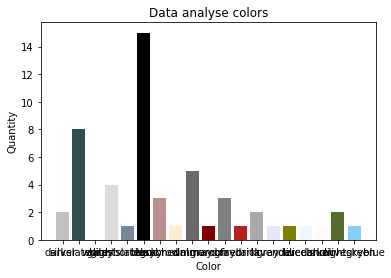

In [108]:
import numpy as np
from matplotlib import pyplot as plt
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
    name_to_rgb,
)

def analysedata(filename):
    colors = []
    colors_quantity = []

    with open(filename) as f:
        datajs = json.load(f)
        for row in datajs:
            colors.append(row.get('Color'))

    for line in colors:
        nbr_colors = colors.count(line)
        colors_quantity.append(nbr_colors)  # , line
    
    plt.title("Data analyse colors")
    names = []
    for i in colors:
        names.append(name_to_rgb(i))

    plt.bar(colors, colors_quantity, color=colors, align='center')
    plt.ylabel('Quantity')
    plt.xlabel('Color')


analysedata('json_data.json')


In [81]:
from sklearn import tree
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import json


def prediction(filename):
    data = []
    with open(filename) as f:
        datajs = json.load(f)
        for index in range(0, 26, 2):
            value = datajs[index]
            val = [value["Category"], value["Color"]]  # ,value["size"]
            data.append(val)

        print(data)

    result = [
        'Favorite',
        'NotFavorite',
        'Favorite',
        'Favorite',
        'Favorite',
        'Favorite',
        'Favorite',
        'NotFavorite',
        'NotFavorite',
        'Favorite',
        'Favorite',
        'NotFavorite',
        'NotFavorite'
    ]

    # creating dataframes
    dataframe = pd.DataFrame(data, columns=['category', 'color'])
    resultframe = pd.DataFrame(result, columns=['favorite'])

    # generating numerical labels
    le1 = LabelEncoder()
    dataframe['category'] = le1.fit_transform(dataframe['category'])

    le2 = LabelEncoder()
    dataframe['color'] = le2.fit_transform(dataframe['color'])

    le3 = LabelEncoder()
    resultframe['favorite'] = le3.fit_transform(resultframe['favorite'])

    # Use of decision tree classifiers
    dtc = tree.DecisionTreeClassifier()
    dtc = dtc.fit(dataframe, resultframe)

    # prediction
    prediction = dtc.predict(
        [[le1.transform(['airplane'])[0], le2.transform(['black'])[0]]])

    print(le3.inverse_transform(prediction))
    print(dtc.feature_importances_)


prediction('json_data.json')


[['airplane', 'silver'], ['airplane', 'white'], ['airplane', 'silver'], ['cat', 'black'], ['cat', 'black'], ['cat', 'rosybrown'], ['cat', 'black'], ['cat', 'dimgray'], ['star', 'black'], ['star', 'black'], ['star', 'black'], ['car', 'black'], ['car', 'darkslategray']]
['NotFavorite']
[0.39842958 0.60157042]


/home/user/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
